In [2]:
from sklearn import metrics
import numpy as np
from classes.boosting_matrix import BoostingMatrix
from classes.dataset import Dataset
from settings import Settings
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from collections import Counter
from classes.pattern_boosting import PatternBoosting
from settings import Settings
from classes.enumeration.estimation_type import EstimationType
from data.synthetic_dataset import SyntheticDataset
from data import data_reader
import pandas as pd
import copy
import matplotlib.pyplot as plt
from classes.analysis import Analysis



Start by loading the model "pattern_boosting" and getting the frequency matrix

In [6]:
directory = data_reader.get_save_location(folder_relative_path="results/jupiter", create_unique_subfolder=True)
pattern_boosting = data_reader.load_data(directory=directory, filename="pattern_boosting")
frequency_matrix = pd.DataFrame(pattern_boosting.boosting_matrix.get_matrix(),
                                columns=pattern_boosting.boosting_matrix.get_header())

Frequency matrix:

In [7]:
tmp = frequency_matrix.sort_values(by=list(frequency_matrix.columns), ascending=False)
tmp.iloc[: 5, : 9]

,"(57,)","(75,)","(72,)","(78,)","(23,)","(26,)","(29,)","(44,)","(41,)"
2997,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
136,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2592,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2399,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3703,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Most common paths (counted by the total number of time they are present):

In [8]:
paths_total_presence = frequency_matrix.sum()
print(paths_total_presence.sort_values(ascending=False)[:5])

(44, 6, 5, 5, 5, 5, 5, 5, 6, 6, 5, 5, 5, 5, 5, 5, 5)          6595.0
(44, 6, 5, 5, 5, 5, 5, 5, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5)       6594.0
(44, 6, 5, 5, 5, 5, 5, 5, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5)       6585.0
(44, 6, 5, 5, 5, 5, 5, 5, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5)    6518.0
(44, 6, 5, 5, 5, 5, 5, 5, 5, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5)    6384.0
dtype: float64


Number of graph a path is present in

In [10]:
presence_per_observation = frequency_matrix.astype(bool).sum(axis=0)
presence_per_observation

(57,)                                                                                                                          7
(75,)                                                                                                                        181
(72,)                                                                                                                         25
(78,)                                                                                                                        429
(23,)                                                                                                                         50
                                                                                                                            ... 
(26, 7, 6, 6, 6, 6, 6, 6, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 6, 6, 6, 6, 6, 6, 6, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7)      1
(26, 7, 6, 6, 6, 6, 6, 6, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 6, 6, 6, 6, 6, 6, 6, 7, 6, 6, 6,

Find paths up to length 'max_length' whose precessors are present in proportion p1,p2,p3, with boundaries "acceptable_error", note the ratio is made on the number of graphs a path is present, NOT the total number of times

In [ ]:
max_length = 4
proportions = [1, 0.5, 0.25, 0.125]
acceptable_error = 0.1

(48)  10 times
(48,7) 5 times

In [16]:
def is_sub_tuple(s, l):
    sub_set = False
    if s == []:
        sub_set = True
    elif s == l:
        sub_set = True
    elif len(s) > len(l):
        sub_set = False

    else:
        for i in range(len(l)):
            if l[i] == s[0]:
                n = 1
                while (n < len(s)) and (l[i + n] == s[n]):
                    n += 1

                if n == len(s):
                    sub_set = True

    return sub_set


def get_ratio_with_next_paths(parent_index, parent_value, presence_per_observation, ratio, acccepred_error):
    founded_paths = []
    ratios = []
    for index, value in presence_per_observation.items():
        if parent_index == index:
            continue
        elif is_sub_tuple(parent_index, index):
            ratio_here = value / parent_value
            if ratio_here - acccepred_error < ratio < ratio_here + acccepred_error:
                ratios.append(ratio_here)
                founded_paths.append(index)
    return ratios, founded_paths


finally_selected_paths = []

for index, value in presence_per_observation.items():
    ratios, founded_paths = get_ratio_with_next_paths(parent_index=index, parent_value=value,
                                                      presence_per_observation=presence_per_observation,
                                                      ratio=proportions[1], acccepred_error=acceptable_error)

    for i, path in enumerate(founded_paths):
        selected_ratios, selected_paths = get_ratio_with_next_paths(parent_index=path,
                                                                    parent_value=presence_per_observation[path],
                                                                    presence_per_observation=presence_per_observation,
                                                                    ratio=proportions[2],
                                                                    acccepred_error=acceptable_error)
        finally_selected_paths = copy.copy(finally_selected_paths + selected_paths)

finally_selected_paths

directory = data_reader.get_save_location(folder_relative_path="results/jupiter", create_unique_subfolder=True)
pattern_boosting = data_reader.save_dataset_in_binary_file(dataset=finally_selected_paths, directory=directory,
                                                           filename="finally_selected_paths", )

TypeError: save_dataset_in_binary_file() missing 1 required positional argument: 'dataset'

Paths that respect the first two ratios:

In [18]:
directory = data_reader.get_save_location(folder_relative_path="results/jupiter", create_unique_subfolder=True)
pattern_boosting = data_reader.load_data(directory=directory, filename="finally_selected_paths")
selected_paths = [item for item in finally_selected_paths if len(item) == 3]

Now we generate the target paths, including the paths of length one and two

In [19]:
target_paths = []
for path in selected_paths:
    for i in range(len(path)):
        target_paths.append(path[:i])

Correlation matrices of subpaths

/Users/popcorn/PycharmProjects/pattern_boosting/venv/lib/python3.11/site-packages/pandas/core/common.py:245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)
/Users/popcorn/PycharmProjects/pattern_boosting/venv/lib/python3.11/site-packages/pandas/core/common.py:245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)
/Users/popcorn/PycharmProjects/pattern_boosting/venv/lib/python3.11/site-packages/pandas/core/common.py:245: VisibleDeprecationWarning: Creating an ndarray from rag

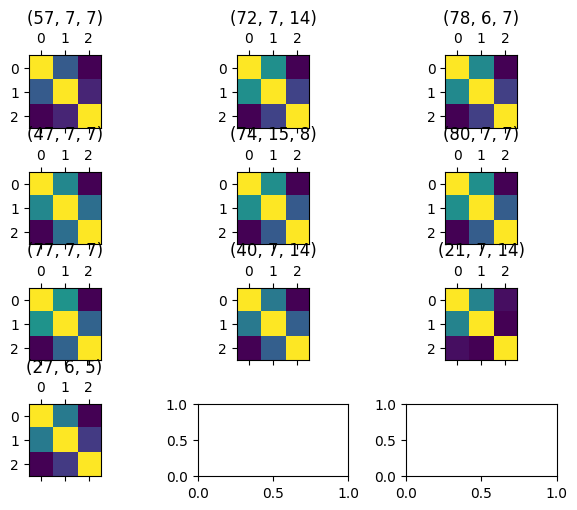

In [32]:
def ceildiv(a, b):
    return -(a // -b)


# number of plots per row
nppr = 3

number_of_plots=10

nr_rows = ceildiv(len(selected_paths[:number_of_plots]), nppr)
fig, axs = plt.subplots(nr_rows, nppr)
fig.tight_layout()

for j, path in enumerate(selected_paths[:number_of_plots]):
    subpaths = []
    for i in range(1, len(path) + 1):
        subpaths.append(path[:i])
        column_number = j % nppr
        row_number = j // nppr
        axs[row_number, column_number].matshow(frequency_matrix[subpaths].corr())
        axs[row_number, column_number].set_title(str(path))

/Users/popcorn/PycharmProjects/pattern_boosting/venv/lib/python3.11/site-packages/pandas/core/common.py:245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)
/Users/popcorn/PycharmProjects/pattern_boosting/venv/lib/python3.11/site-packages/pandas/core/common.py:245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)
/Users/popcorn/PycharmProjects/pattern_boosting/venv/lib/python3.11/site-packages/pandas/core/common.py:245: VisibleDeprecationWarning: Creating an ndarray from rag

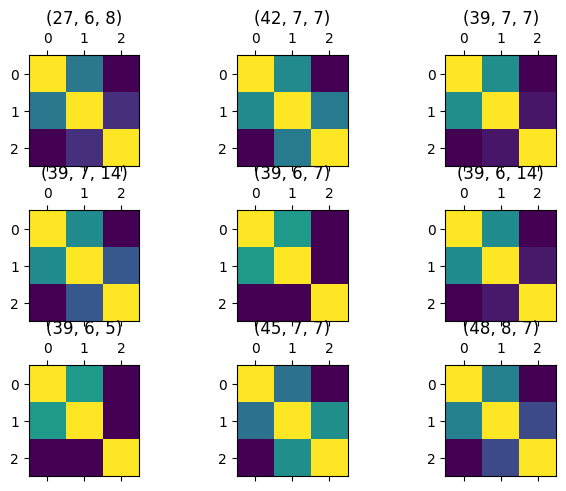

In [31]:
nr_rows = ceildiv(len(selected_paths[number_of_plots:]), nppr)
fig, axs = plt.subplots(nr_rows, nppr)
fig.tight_layout()


for j, path in enumerate(selected_paths[number_of_plots:]):
    subpaths = []
    for i in range(1, len(path) + 1):
        subpaths.append(path[:i])
        column_number = j % nppr
        row_number = j // nppr
        axs[row_number, column_number].matshow(frequency_matrix[subpaths].corr())
        axs[row_number, column_number].set_title(str(path))

Correlation matrix over all the paths

/Users/popcorn/PycharmProjects/pattern_boosting/venv/lib/python3.11/site-packages/pandas/core/common.py:245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


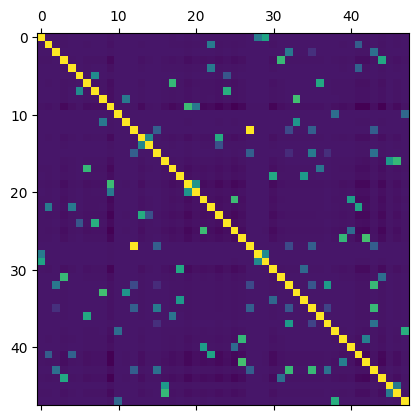

In [28]:
target_paths = list({(57, 7, 7), (57, 7), (57,),
                     (72, 7, 14), (72, 7), (72,),
                     (78, 6, 7), (78, 6), (78,),
                     (47, 7, 7), (47, 7), (47,),
                     (74, 15, 8), (74, 15), (74,),
                     (80, 7, 7), (80, 7), (80,),
                     (77, 7, 7), (77, 7), (77,),
                     (40, 7, 14), (40, 7), (40,),
                     (21, 7, 14), (21, 7), (21,),
                     (27, 6, 5), (27, 6), (27,),
                     (27, 6, 8),
                     (42, 7, 7), (42, 7), (42,),
                     (39, 7, 7), (39, 7), (39,),
                     (39, 7, 14),
                     (39, 6, 7), (39, 6),
                     (39, 6, 14),
                     (39, 6, 5),
                     (45, 7, 7), (45, 7), (45,),
                     (48, 8, 7), (48, 8), (48,)})
plt.matshow(frequency_matrix[target_paths].corr())


[11:58:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[11:58:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences

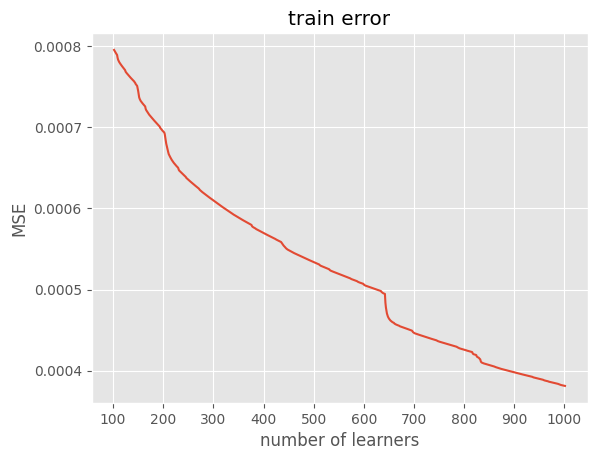

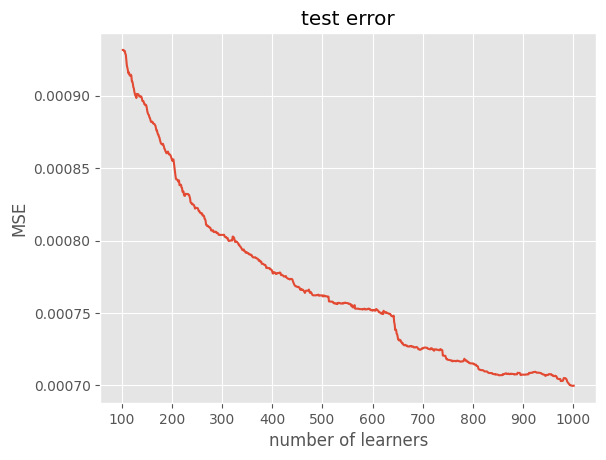

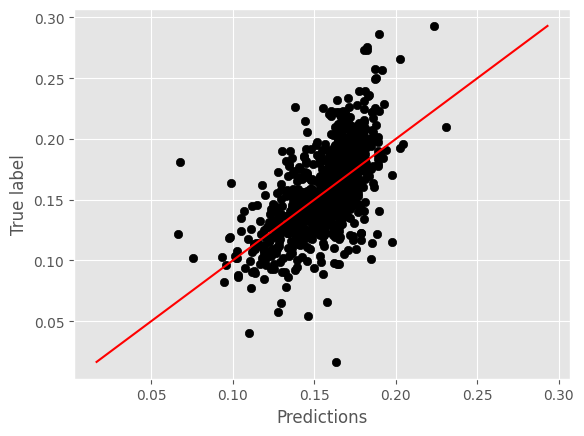

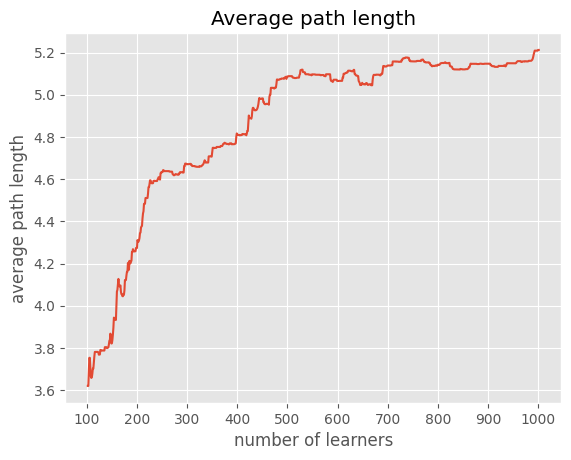

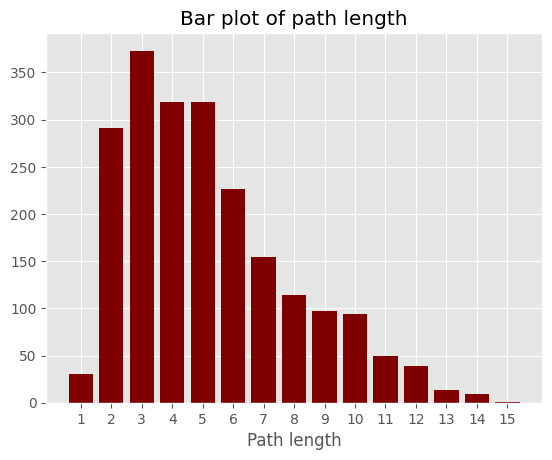

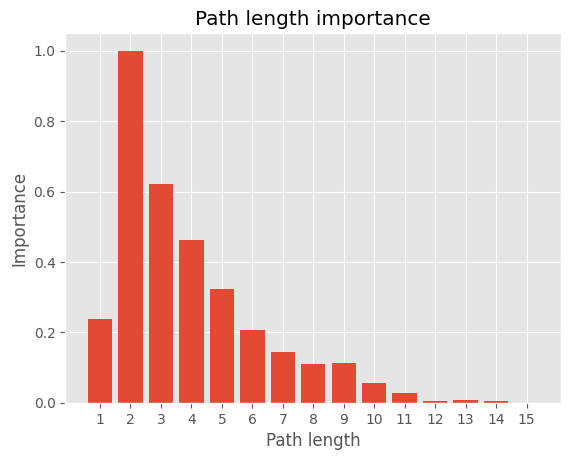

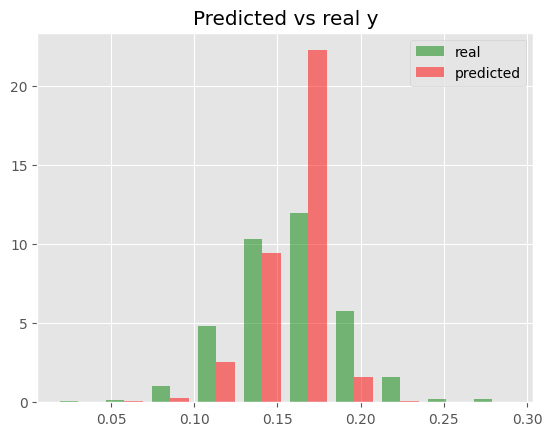


--------------------------------------------------------------------------------
Training dataset dimension: 4000
Test dataset dimension: 1000
Number of iterations: 1001
Number of iterations: 1001
Boosting Matrix:
Boosting matrix header:
[(57,), (75,), (72,), (78,), (23,), (26,), (29,), (44,), (41,), (47,), (74,), (80,), (25,), (77,), (22,), (28,), (40,), (43,), (46,), (73,), (76,), (21,), (79,), (24,), (30,), (27,), (42,), (39,), (45,), (48,), (28, 17), (28, 7), (28, 16), (28, 35), (28, 9), (28, 53), (28, 6), (28, 15), (28, 5), (28, 34), (28, 8), (28, 14), (28, 7, 16), (28, 7, 6), (28, 7, 8), (28, 7, 14), (28, 7, 7), (79, 17), (79, 7), (79, 53), (79, 16), (79, 6), (79, 35), (79, 15), (79, 34), (79, 8), (23, 17), (23, 7), (23, 16), (23, 35), (23, 9), (23, 6), (23, 15), (23, 5), (23, 8), (23, 14), (30, 8), (30, 53), (30, 17), (30, 1), (30, 7), (30, 16), (30, 6), (30, 35), (30, 9), (30, 15), (30, 34), (75, 16), (75, 6), (75, 35), (75, 53), (75, 15), (75, 34), (75, 8), (75, 14), (75, 33)

In [4]:
analysis = Analysis()
directory=data_reader.get_save_location(folder_relative_path="results")
directory='/Users/popcorn/PycharmProjects/pattern_boosting/results/Xgb_step_1001_max_path_length_100_5_k_selection_graphs'

analysis.load_and_analyze(directory=directory,
                              show=True,
                              save=True)

[12:33:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[12:33:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences

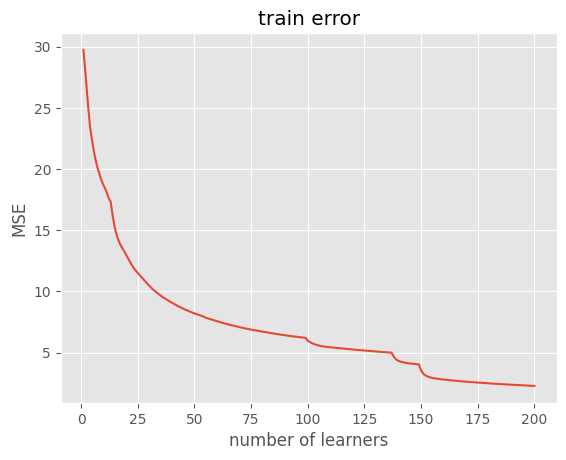

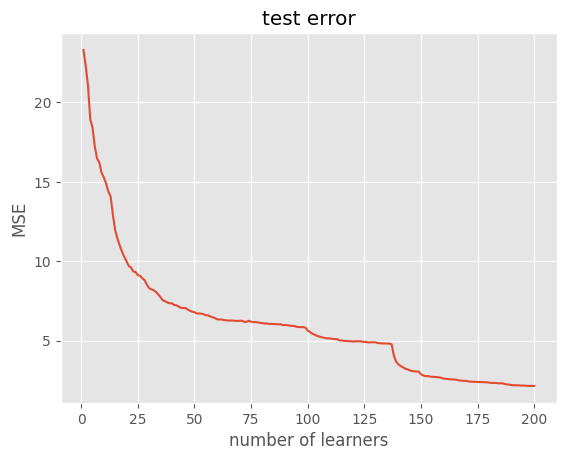

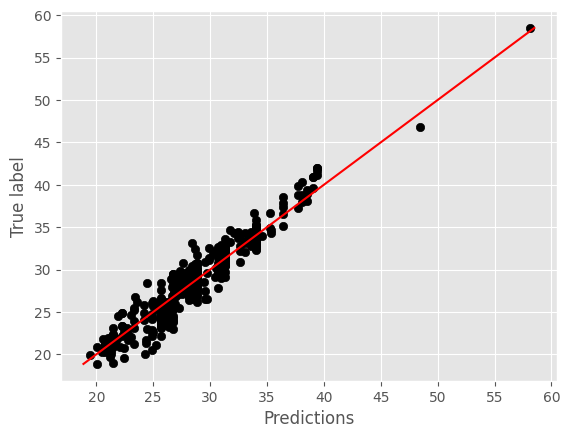

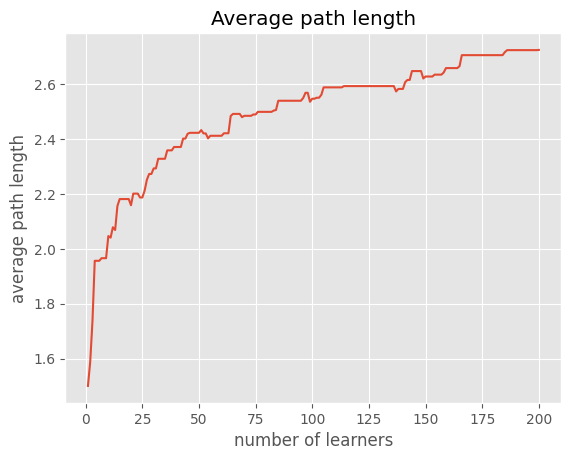

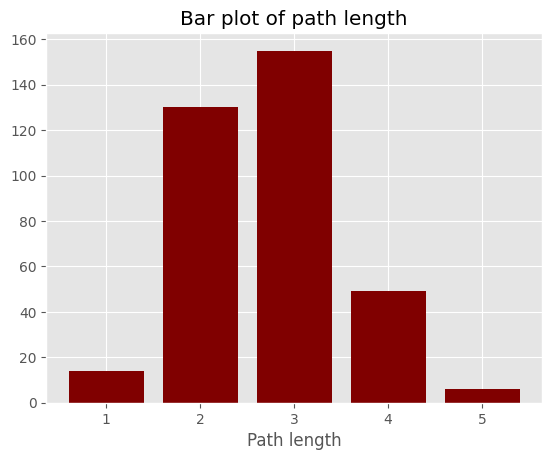

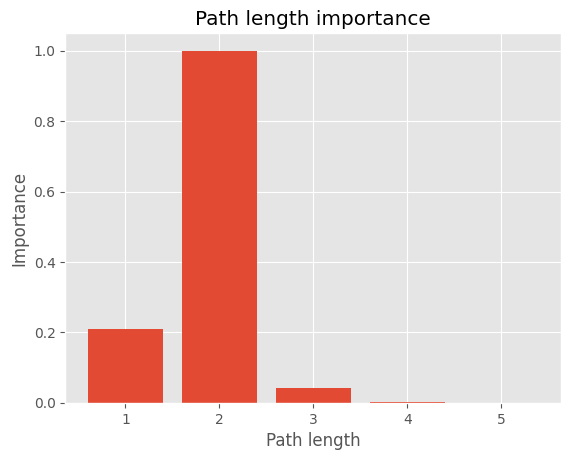

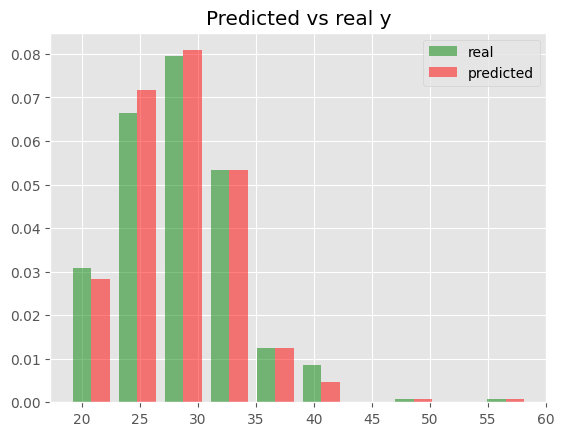


--------------------------------------------------------------------------------
Training dataset dimension: 1533
Test dataset dimension: 384
Number of iterations: 200
Number of iterations: 200
Boosting Matrix:
Boosting matrix header:
[(57,), (47,), (21,), (40,), (27,), (78,), (72,), (42,), (39,), (45,), (74,), (80,), (48,), (77,), (78, 53), (78, 14), (78, 33), (78, 17), (78, 7), (78, 16), (78, 6), (78, 35), (78, 9), (78, 8), (78, 15), (78, 5), (78, 34), (78, 1), (39, 8), (39, 5), (39, 14), (39, 17), (39, 7), (39, 6), (39, 6, 7), (39, 6, 14), (39, 6, 5), (39, 6, 6), (78, 6, 5), (78, 6, 8), (78, 6, 14), (78, 6, 17), (78, 6, 7), (78, 6, 16), (78, 6, 9), (78, 6, 6), (42, 16), (42, 35), (42, 6), (42, 15), (42, 5), (42, 34), (42, 8), (42, 14), (42, 53), (42, 33), (42, 17), (42, 1), (42, 7), (42, 8, 6), (42, 8, 15), (42, 8, 8), (42, 8, 7), (42, 8, 16), (48, 15), (48, 53), (48, 17), (48, 7), (48, 16), (48, 6), (48, 35), (48, 34), (48, 8), (48, 8, 7), (48, 8, 16), (48, 8, 6), (27, 8), (27, 53

In [5]:
analysis = Analysis()
directory=data_reader.get_save_location(folder_relative_path="results")
directory='/Users/popcorn/PycharmProjects/pattern_boosting/results/Xgb_step_200_max_path_length_100_5k_synthetic_dataset'

analysis.load_and_analyze(directory=directory,
                              show=True,
                              save=True)